# Time Series Anomaly Detection in Mackey-Glass Time Series with TCN-AE

In [1]:
import numpy
from utilities import select_gpus, plot_results # utilities.py: Contains a few miscellaneous functions 
from tcnae import TCNAE # tcnae.py: Specification of the TCN-AE model
import data # data.py: Allows to generate anomalous Mackey-Glass (MG) time series 

# If you have several GPUs, select one or more here (in a list)
select_gpus(0)

selected GPUs: 0


In [2]:
train_ts_id = 1 # [1-10]. Train the model on Mackey-Glass time series 1
data_gen = data.Data()
train_data = data_gen.build_data(train_ts_id, verbose = 0) # Returns a dictionary
train_X = train_data["train_X"] # We only need train_X (input = output) for the training process
print("train_X.shape:", train_X.shape) # A lot of training sequences of length 1050 and dimension 1

train_X.shape: (19791, 1050, 1)


In [3]:
# Build and compile the model
tcn_ae = TCNAE() # Use the parameters specified in the paper

# Train TCN-AE
tcn_ae.fit(train_X, train_X, batch_size=32, epochs=40, verbose=1)

> Starting the Training...
Epoch 1/40
618/618 - 17s - loss: 0.0247 - logcosh: 0.0247 - val_loss: 0.0014 - val_logcosh: 0.0014
Epoch 2/40
618/618 - 16s - loss: 0.0015 - logcosh: 0.0015 - val_loss: 0.0015 - val_logcosh: 0.0015
Epoch 3/40
618/618 - 17s - loss: 9.8799e-04 - logcosh: 9.8799e-04 - val_loss: 7.6269e-04 - val_logcosh: 7.6269e-04
Epoch 4/40
618/618 - 16s - loss: 7.5475e-04 - logcosh: 7.5475e-04 - val_loss: 5.8364e-04 - val_logcosh: 5.8364e-04
Epoch 5/40
618/618 - 15s - loss: 6.3396e-04 - logcosh: 6.3396e-04 - val_loss: 4.5739e-04 - val_logcosh: 4.5739e-04
Epoch 6/40
618/618 - 15s - loss: 5.6598e-04 - logcosh: 5.6598e-04 - val_loss: 4.5888e-04 - val_logcosh: 4.5888e-04
Epoch 7/40
618/618 - 17s - loss: 5.1901e-04 - logcosh: 5.1901e-04 - val_loss: 4.0655e-04 - val_logcosh: 4.0655e-04
Epoch 8/40
618/618 - 17s - loss: 4.6829e-04 - logcosh: 4.6829e-04 - val_loss: 3.6339e-04 - val_logcosh: 3.6339e-04
Epoch 9/40
618/618 - 17s - loss: 4.4488e-04 - logcosh: 4.4488e-04 - val_loss: 3.3926e

In [4]:
# Test the model on another Mackey-Glass time series
# Might take a few minutes...
test_ts_id = 3 # Test the model on Mackey-Glass time series 3
test_data = data_gen.build_data(test_ts_id, verbose = 0) # Returns a dictionary

# Take the whole time series... Like the training data, the test data is standardized (zero mean and unit variance)
test_X = test_data["scaled_series"].values[numpy.newaxis,:,:] # We need an extra dimension for the batch-dimension
print("test_X.shape", test_X.shape) # This is one long time series
anomaly_score = tcn_ae.predict(test_X)

test_X.shape (1, 100000, 1)


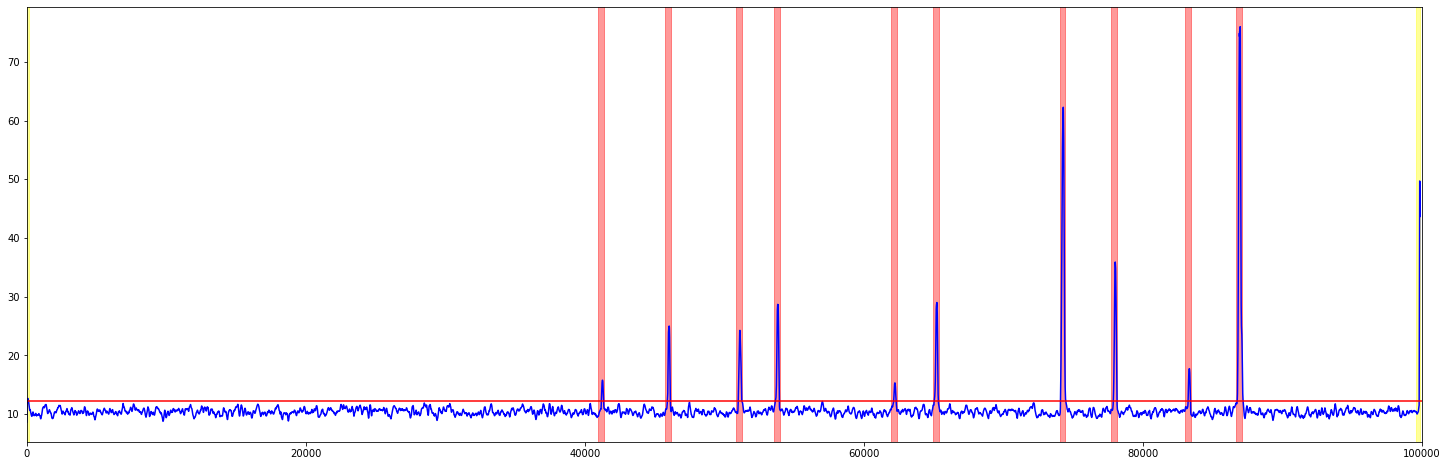

In [5]:
# Make a plot of the anomaly-score and see how it matches the real anomaly windows
# Red bars show the actual anomalies
# Yellow bars show regions which can be ignored (usually start and end of a time series, which lead to transient behavior)
# The blue curve is the Anomaly Score
# The red horizontal line indicates a simple threshold, which is the smallest possible value that would not produce a false positive
plot_results(test_data, anomaly_score, pl_range = None, plot_signal = False, plot_anomaly_score = True)

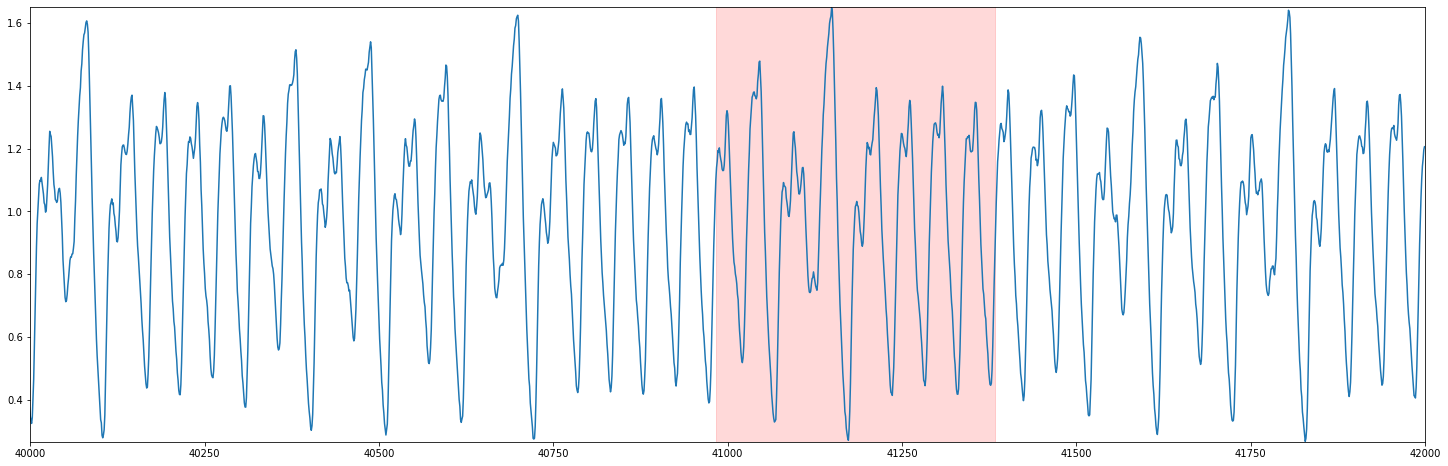

In [6]:
# Take a look at the MG time series: zoom into the first anomaly
plot_results(test_data, anomaly_score, pl_range = (40000, 42000), plot_signal = True, plot_anomaly_score = False)